In [1]:
!pip install fastparquet   
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install scikit-learn


--- Fetching and Storing Full Portfolio Data ---
Fetching QQQ (full history)...
Successfully fetched and saved 668 records for QQQ to ticker_data_parquet/QQQ.parquet
Fetching MSFT (full history)...
Successfully fetched and saved 668 records for MSFT to ticker_data_parquet/MSFT.parquet

✅ All available data fetched and stored as individual parquet files successfully!
Fetched tickers: ['QQQ', 'MSFT']

--- Plotting Individual Ticker Performance (from parquet) ---


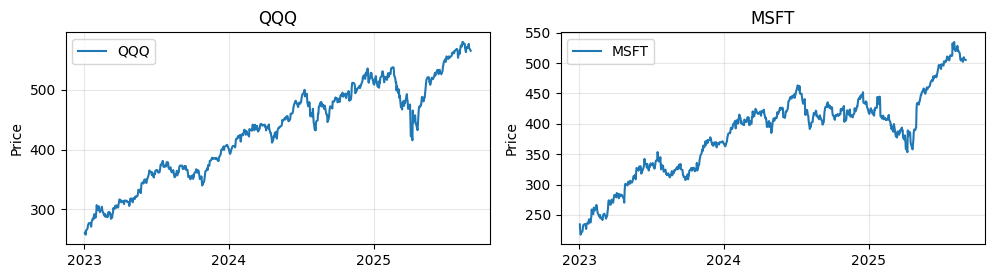


--- Data Fetching, Storing, and Plotting Complete ---


In [2]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json # Explicitly import json
import os # Import os to manage directories

# -------------------------------------------------------------
# Portfolio Configuration
# (Combines content from your previous Cell 2 and Cell 3)
# -------------------------------------------------------------
API_KEY = "1VWXIAX2LM6F6WV0" # Your Alpha Vantage API key
START_YEAR = 2023            # Filter data from this year onwards

TICKERS = [ "QQQ" , "MSFT"
    # Nasdaq Top 20 (US Equities - Large Cap)
    # "NVDA", "MSFT", "AAPL", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "TSM", "INTC",
    # "ADBE", "CMCSA", "CSCO", "PEP", "TXN", "PYPL", "QCOM", "AMGN", "GILD", "CHTR",

    # # Europe Top (European Equities - Broad/Large Cap)
    # "SAP", "ASML", "MC.PA", "RMS.PA", "OR.PA", "AZN", "VGK",

    # # Asia/Global Diversifiers (Asian Equities & Resources)
    # "XOM", "TSM", "TCEHY", "FXI", "EWY",

    # Crypto (from Alpha Vantage, use SYMBOL-USD format)
    # "BTC-USD", "ETH-USD"
]

# -------------------------------------------------------------
# Robust Data Fetching Function
# (Content from your previous working fetch_alpha_vantage_data_robust function)
# -------------------------------------------------------------
def fetch_alpha_vantage_data_robust(ticker: str, api_key: str, output_size: str = "full") -> pd.DataFrame | None:
    """
    Fetch daily OHLCV data from Alpha Vantage for a single ticker (adjusted for stocks).
    Handles both TIME_SERIES_DAILY_ADJUSTED for stocks and DIGITAL_CURRENCY_DAILY for crypto.
    """
    base_url = "https://www.alphavantage.co/query"
    df = None

    def print_common_msgs(j: dict, ticker: str) -> bool:
        """Prints common Alpha Vantage messages (Note, Error Message, etc.) and indicates if it's a failure."""
        is_failure = False
        for k in ("Note", "Error Message", "Information", "Message"):
            if k in j:
                print(f"{ticker}: {k}: {j[k]}")
                if k in ("Error Message", "Information", "Message") or "frequency" in j[k].lower():
                    is_failure = True
        return is_failure

    # Crypto data
    if ticker.endswith("-USD"):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": ticker.split("-")[0],
            "market": "USD",
            "apikey": api_key,
        }
        try:
            r = requests.get(base_url, params=params, timeout=20)
            r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            j = r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {ticker}: {e}")
            return None
        except json.JSONDecodeError:
            print(f"{ticker}: Response not JSON: {r.text[:200]}")
            return None

        if print_common_msgs(j, ticker):
            return None

        key = "Time Series (Digital Currency Daily)"
        if key not in j:
            print(f"{ticker}: missing '{key}' in response for crypto")
            return None

        ts = j[key]
        df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
        df.index = pd.to_datetime(df.index)

        # Crypto close column is '4. close' based on your diagnostic
        close_col = "4. close"

        if close_col not in df.columns:
            print(f"{ticker}: close column not found in crypto payload. Available: {df.columns.tolist()}")
            return None

        df = df.rename(columns={close_col: "Close"})
        df = df[["Close", "1. open", "2. high", "3. low"]].sort_index() # Include Open, High, Low
        df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low"}) # Rename for consistency
        df["Ticker"] = ticker
        return df

    # Stock data (adjusted for splits)
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker,
        "outputsize": output_size,
        "apikey": api_key,
    }
    try:
        r = requests.get(base_url, params=params, timeout=20)
        r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        j = r.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {ticker}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"{ticker}: Response not JSON: {r.text[:200]}")
        return None

    if print_common_msgs(j, ticker):
        return None

    # Accept either "Time Series (Daily Adjusted)" or "Time Series (Daily)" keys
    key = None
    if "Time Series (Daily Adjusted)" in j:
        key = "Time Series (Daily Adjusted)"
    elif "Time Series (Daily)" in j:
        key = "Time Series (Daily)"

    if key is None:
        print(f"{ticker}: no daily time series key present in response")
        return None

    ts = j[key]
    df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
    df.index = pd.to_datetime(df.index)

    # Prefer adjusted close when available, else fallback to raw close
    close_col = None
    if "5. adjusted close" in df.columns:
        close_col = "5. adjusted close"
    elif "4. close" in df.columns:
        close_col = "4. close"

    if close_col is None:
        print(f"{ticker}: no close column found (expected '5. adjusted close' or '4. close'). Available: {df.columns.tolist()}")
        return None

    # Include '1. open', '2. high', '3. low' for stocks
    df = df.rename(columns={
        close_col: "Close",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "6. volume": "Volume" # Include volume as well
    })
    # Select desired columns and ensure correct order
    df = df[["Open", "High", "Low", "Close", "Volume"]].sort_index()
    df["Ticker"] = ticker
    return df

# -------------------------------------------------------------
# Main Data Fetching and Storing Workflow
# -------------------------------------------------------------
print("\n--- Fetching and Storing Full Portfolio Data ---")
# Create a directory to store individual ticker data if it doesn't exist
output_dir = "ticker_data_parquet"
os.makedirs(output_dir, exist_ok=True)

fetched_tickers = []

for ticker in TICKERS:
    print(f"Fetching {ticker} (full history)...")
    # Using the robust fetcher with output_size='full'
    df = fetch_alpha_vantage_data_robust(ticker, API_KEY, output_size="full")

    if df is not None:
        # Filter from START_YEAR
        df = df[df.index.year >= START_YEAR]

        # Save individual ticker data to a parquet file
        file_path = os.path.join(output_dir, f"{ticker}.parquet")
        df.to_parquet(file_path)
        print(f"Successfully fetched and saved {len(df)} records for {ticker} to {file_path}")
        fetched_tickers.append(ticker)

        # Explicitly delete the DataFrame to free up memory
        del df

    time.sleep(12) # Respect Alpha Vantage API limit (5 requests/minute)

if not fetched_tickers:
    raise RuntimeError("No data was fetched for any ticker from Alpha Vantage. Please check API key, internet connection, or ticker symbols.")

print("\n✅ All available data fetched and stored as individual parquet files successfully!")
print(f"Fetched tickers: {fetched_tickers}")

# Note: The combined 'data' DataFrame is no longer created directly in memory.
# You will need to load data for analysis from the individual parquet files.

# -------------------------------------------------------------
# Plotting - Individual Ticker Performance (small multiples)
# (Modified to load data from parquet files)
# -------------------------------------------------------------
print("\n--- Plotting Individual Ticker Performance (from parquet) ---")
tickers_to_plot = fetched_tickers # Plot only the tickers for which data was fetched
n_plots = len(tickers_to_plot)

if n_plots > 0:
    # Determine grid size for subplots
    n_cols = 3 # You can adjust this for wider or narrower grids
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig_multiples, axes_multiples = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True)
    axes_multiples = axes_multiples.flatten() # Flatten for easy iteration

    for i, ticker in enumerate(tickers_to_plot):
        ax = axes_multiples[i]
        file_path = os.path.join(output_dir, f"{ticker}.parquet")

        try:
            # Load data for the individual ticker from its parquet file
            ticker_data = pd.read_parquet(file_path)

            # Ensure unique index by grouping on Date if duplicates exist (shouldn't if data is clean)
            if not ticker_data.index.is_unique:
                ticker_data = ticker_data.groupby(ticker_data.index).mean(numeric_only=True)

            # Plot closing price, ensuring 'Close' column exists
            if 'Close' in ticker_data.columns:
                ax.plot(ticker_data.index, ticker_data['Close'], label=ticker, linewidth=1.5)
            else:
                print(f"⚠️ Warning: 'Close' column not found in parquet for {ticker}. Skipping individual plot.")
                continue

            # Formatting
            ax.set_title(ticker)
            ax.set_ylabel('Price')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left')

        except FileNotFoundError:
            print(f"⚠️ Warning: Parquet file not found for {ticker}. Skipping individual plot.")
            continue

    # Set common X-axis locators/formatters only on the bottom row for clarity
    for ax_row in axes_multiples.reshape(n_rows, n_cols)[-1]:
        ax_row.xaxis.set_major_locator(mdates.YearLocator())
        ax_row.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide any unused subplots
    for j in range(i + 1, len(axes_multiples)):
        fig_multiples.delaxes(axes_multiples[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()
else:
    print("No tickers to plot.")


print("\n--- Data Fetching, Storing, and Plotting Complete ---")

In [3]:
# In the previous cell, data is now saved as individual parquet files per ticker.
# Load individual ticker data and combine them into a single DataFrame.

all_data_frames = []
output_dir = "ticker_data_parquet"

# Iterate through the fetched tickers and load their parquet files
for ticker in fetched_tickers:
    file_path = os.path.join(output_dir, f"{ticker}.parquet")
    try:
        ticker_df = pd.read_parquet(file_path)
        all_data_frames.append(ticker_df)
    except FileNotFoundError:
        print(f"Warning: Parquet file not found for {ticker}. Skipping.")
        continue

if all_data_frames:
    # Combine all individual DataFrames into a single one
    data = pd.concat(all_data_frames)

    # Save the combined data to a Parquet file
    data.to_parquet("portfolio_data.parquet")
    print("Combined data saved to portfolio_data.parquet")

    # Load the data from the Parquet file to verify
    loaded_data = pd.read_parquet("portfolio_data.parquet")

    # Reorder columns to have 'Ticker' as the first column
    cols = ['Ticker'] + [col for col in loaded_data.columns if col != 'Ticker']
    loaded_data = loaded_data[cols]

    # Display the first few rows of the loaded data
    display(loaded_data.head())

else:
    print("No data frames were loaded to combine.")

Combined data saved to portfolio_data.parquet


,Ticker,Open,High,Low,Close,Volume
2023-01-03,QQQ,268.65,270.155,262.13,260.449963,42335325.0
2023-01-04,QQQ,266.64,267.450,262.53,261.690763,47754861.0
2023-01-05,QQQ,264.04,264.210,261.26,257.594152,45396744.0
2023-01-06,QQQ,263.35,269.940,260.34,264.704136,54659739.0
2023-01-09,QQQ,270.83,275.290,269.92,266.417623,45568676.0


vectors, parquets, dask,

van hier uit, gewoon stap per stap de oude notebook opnieuw overnemen, het zou goed moeten kunnen, gewoon, ombouwen pretty much, logica dieper pakken, meteen op schaal gaan, meer documenteren, robustness test inbouwen etc. meteen

train / test data split voor in and out of sample,

rolling sharpe etc.

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y). Assuming 'Close' is the target.
# You might need to adjust features based on your model's needs.
X = loaded_data.drop(columns=['Close', 'Ticker']) # Example: dropping 'Close' and 'Ticker' as features
y = loaded_data['Close']
tickers = loaded_data['Ticker'] # Keep track of tickers

# Split the data while maintaining the time series order.
# We will use the index (Date) to split the data.
# The split point will be 80% of the way through the sorted index.

# Sort the data by index (Date) to ensure proper time series splitting
loaded_data_sorted = loaded_data.sort_index()


# Calculate the split point index
split_index = int(len(loaded_data_sorted) * 0.8)


# Split the data based on the calculated index
train_data = loaded_data_sorted.iloc[:split_index]
test_data = loaded_data_sorted.iloc[split_index:]

print("Data split into training and testing sets.")
print(f"Training set shape: {train_data.shape}")
print(f"Testing set shape: {test_data.shape}")

display(train_data.head())
display(test_data.head())

Data split into training and testing sets.
Training set shape: (1068, 6)
Testing set shape: (268, 6)


,Ticker,Open,High,Low,Close,Volume
2023-01-03,QQQ,268.650,270.155,262.13,260.449963,42335325.0
2023-01-03,MSFT,243.080,245.750,237.40,234.439879,25740036.0
2023-01-04,MSFT,232.275,232.870,225.96,224.184724,50623394.0
2023-01-04,QQQ,266.640,267.450,262.53,261.690763,47754861.0
2023-01-05,QQQ,264.040,264.210,261.26,257.594152,45396744.0


,Ticker,Open,High,Low,Close,Volume
2025-02-20,QQQ,538.730,539.100,532.46,535.851720,26550753.0
2025-02-20,MSFT,415.290,419.310,412.54,414.686575,23508728.0
2025-02-21,QQQ,538.380,538.400,525.71,524.730325,47093750.0
2025-02-21,MSFT,417.335,418.048,407.89,406.794047,27524799.0
2025-02-24,QQQ,527.880,529.069,519.53,518.536257,39268392.0


In [5]:
# Parameter grid for EMA Triple Crossover, MACD, and AROON
import itertools as it

# EMA Triple Crossover parameters (Fast < Medium < Slow)
EMA_FAST_RANGE = list(range(2, 20, 3))       # 5, 7, 9, ..., 19
EMA_MEDIUM_RANGE = list(range(25, 75, 5))    # 15, 20, 25, ..., 50
EMA_SLOW_RANGE = list(range(100, 200, 10))    # 50, 60, 70, ..., 200

# MACD parameters
MACD_FAST_RANGE = list(range(26, 76, 3))      # 8, 10, 12, ..., 20
MACD_SLOW_RANGE = list(range(50, 101, 6))     # 21, 24, 27, ..., 39
MACD_SIGNAL_RANGE = list(range(14, 28, 2))    # 6, 8, 10, 12, 14

# AROON parameters
AROON_PERIOD_RANGE = list(range(55, 110, 3))  # 10, 15, 20, 25, 30

ALL_PARAM_COMBINATIONS = [
    (ema_fast, ema_medium, ema_slow, macd_fast, macd_slow, macd_signal, aroon_period)
    for ema_fast, ema_medium, ema_slow, macd_fast, macd_slow, macd_signal, aroon_period in it.product(
        EMA_FAST_RANGE, EMA_MEDIUM_RANGE, EMA_SLOW_RANGE, 
        MACD_FAST_RANGE, MACD_SLOW_RANGE, MACD_SIGNAL_RANGE, 
        AROON_PERIOD_RANGE
    )
    if ema_fast < ema_medium < ema_slow and macd_fast < macd_slow
]

print(f"Total param combos: {len(ALL_PARAM_COMBINATIONS):,}")
print("Example first 10:")
print(ALL_PARAM_COMBINATIONS[:10])
print()
print("Parameter ranges:")
print(f"EMA Fast: {min(EMA_FAST_RANGE)} to {max(EMA_FAST_RANGE)}")
print(f"EMA Medium: {min(EMA_MEDIUM_RANGE)} to {max(EMA_MEDIUM_RANGE)}")
print(f"EMA Slow: {min(EMA_SLOW_RANGE)} to {max(EMA_SLOW_RANGE)}")
print(f"MACD Fast: {min(MACD_FAST_RANGE)} to {max(MACD_FAST_RANGE)}")
print(f"MACD Slow: {min(MACD_SLOW_RANGE)} to {max(MACD_SLOW_RANGE)}")
print(f"MACD Signal: {min(MACD_SIGNAL_RANGE)} to {max(MACD_SIGNAL_RANGE)}")
print(f"AROON Period: {min(AROON_PERIOD_RANGE)} to {max(AROON_PERIOD_RANGE)}")

Total param combos: 10,214,400
Example first 10:
[(2, 25, 100, 26, 50, 14, 55), (2, 25, 100, 26, 50, 14, 58), (2, 25, 100, 26, 50, 14, 61), (2, 25, 100, 26, 50, 14, 64), (2, 25, 100, 26, 50, 14, 67), (2, 25, 100, 26, 50, 14, 70), (2, 25, 100, 26, 50, 14, 73), (2, 25, 100, 26, 50, 14, 76), (2, 25, 100, 26, 50, 14, 79), (2, 25, 100, 26, 50, 14, 82)]

Parameter ranges:
EMA Fast: 2 to 17
EMA Medium: 25 to 70
EMA Slow: 100 to 190
MACD Fast: 26 to 74
MACD Slow: 50 to 98
MACD Signal: 14 to 26
AROON Period: 55 to 109


In [6]:
# New indicators: EMA Triple Crossover, MACD, and AROON with event-based signals
import numpy as np
import pandas as pd


def cross_up(x: pd.Series, y: pd.Series) -> pd.Series:
    """Detect when x crosses above y"""
    return (x > y) & (x.shift(1) <= y.shift(1))


def cross_down(x: pd.Series, y: pd.Series) -> pd.Series:
    """Detect when x crosses below y"""
    return (x < y) & (x.shift(1) >= y.shift(1))


def ema(series: pd.Series, length: int) -> pd.Series:
    """Exponential Moving Average"""
    return series.ewm(span=length, adjust=False).mean()


def compute_macd(close: pd.Series, fast_len: int, slow_len: int, signal_len: int) -> tuple:
    """
    Compute MACD line, signal line, and histogram
    Returns: (macd_line, signal_line, histogram)
    """
    ema_fast = ema(close, fast_len)
    ema_slow = ema(close, slow_len)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal_len)
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram


def compute_aroon(high: pd.Series, low: pd.Series, period: int) -> tuple:
    """
    Compute AROON Up and AROON Down
    Returns: (aroon_up, aroon_down)
    """
    def rolling_argmax_argmin(series, window):
        """Get position of max/min in rolling window"""
        return series.rolling(window=window).apply(
            lambda x: window - 1 - x.argmax() if len(x) == window else np.nan, 
            raw=False
        ), series.rolling(window=window).apply(
            lambda x: window - 1 - x.argmin() if len(x) == window else np.nan, 
            raw=False
        )
    
    periods_since_high, periods_since_low = rolling_argmax_argmin(high, period), rolling_argmax_argmin(low, period)
    
    # AROON calculation: ((period - periods_since) / period) * 100
    aroon_up = ((period - periods_since_high[0]) / period) * 100
    aroon_down = ((period - periods_since_low[1]) / period) * 100
    
    return aroon_up, aroon_down


def compute_indicators_for_group(
    group_df: pd.DataFrame,
    ema_fast_len: int,
    ema_medium_len: int, 
    ema_slow_len: int,
    macd_fast_len: int,
    macd_slow_len: int,
    macd_signal_len: int,
    aroon_period: int,
) -> pd.DataFrame:
    """
    Compute all indicators and generate event-based signals:
    1. EMA Triple Crossover (Fast/Medium/Slow)
    2. MACD (Line crossing Signal)
    3. AROON (Up/Down crossover at 50 level and extreme levels)
    """
    df = group_df.copy()
    close = df["Close"]
    high = df["High"]
    low = df["Low"]

    # === EMA Triple Crossover ===
    df["EMA_Fast"] = ema(close, ema_fast_len)
    df["EMA_Medium"] = ema(close, ema_medium_len)
    df["EMA_Slow"] = ema(close, ema_slow_len)

    # EMA Triple signals: Buy when Fast > Medium > Slow alignment occurs
    # Sell when the opposite alignment occurs
    bullish_alignment = (df["EMA_Fast"] > df["EMA_Medium"]) & (df["EMA_Medium"] > df["EMA_Slow"])
    bearish_alignment = (df["EMA_Fast"] < df["EMA_Medium"]) & (df["EMA_Medium"] < df["EMA_Slow"])
    
    # Event-based: signal only on the bar when alignment changes
    # Avoid FutureWarning by handling NaN values without fillna on boolean Series
    prev_bullish = bullish_alignment.shift(1)
    prev_bearish = bearish_alignment.shift(1)
    
    # Handle NaN values: where prev is NaN, treat as False (no previous alignment)
    # This avoids fillna on boolean Series which triggers FutureWarning
    ema_buy = bullish_alignment & (prev_bullish != True)
    ema_sell = bearish_alignment & (prev_bearish != True)
    
    ema_sig = pd.Series(0, index=df.index, dtype="int8")
    ema_sig.loc[ema_buy] = 1
    ema_sig.loc[ema_sell] = -1
    df["Buy_EMA_Triple"] = ema_sig

    # === MACD ===
    macd_line, signal_line, histogram = compute_macd(close, macd_fast_len, macd_slow_len, macd_signal_len)
    df["MACD_Line"] = macd_line
    df["MACD_Signal"] = signal_line
    df["MACD_Histogram"] = histogram

    # MACD signals: Buy when MACD crosses above Signal, Sell when below
    macd_buy = cross_up(macd_line, signal_line)
    macd_sell = cross_down(macd_line, signal_line)
    
    macd_sig = pd.Series(0, index=df.index, dtype="int8")
    macd_sig.loc[macd_buy] = 1
    macd_sig.loc[macd_sell] = -1
    df["Buy_MACD_Cross"] = macd_sig

    # === AROON ===
    aroon_up, aroon_down = compute_aroon(high, low, aroon_period)
    df["AROON_Up"] = aroon_up
    df["AROON_Down"] = aroon_down

    # AROON signals: Multiple strategies
    # 1. Buy when AROON Up crosses above 50, Sell when AROON Down crosses above 50
    aroon_up_buy = cross_up(aroon_up, pd.Series(50, index=df.index))
    aroon_down_sell = cross_up(aroon_down, pd.Series(50, index=df.index))
    
    # 2. Also signal on extreme levels (AROON Up > 70 for strong uptrend)
    aroon_extreme_buy = cross_up(aroon_up, pd.Series(70, index=df.index))
    aroon_extreme_sell = cross_up(aroon_down, pd.Series(70, index=df.index))
    
    # Combine AROON signals
    aroon_buy = aroon_up_buy | aroon_extreme_buy
    aroon_sell = aroon_down_sell | aroon_extreme_sell
    
    aroon_sig = pd.Series(0, index=df.index, dtype="int8")
    aroon_sig.loc[aroon_buy] = 1
    aroon_sig.loc[aroon_sell] = -1
    df["Buy_AROON_Cross"] = aroon_sig

    return df



In [ ]:
# Full pipeline cell: load training Parquet, run Dask grid with progress prints, write Parquet batches
from pathlib import Path
from typing import Any, Mapping, Tuple, List
import logging
import os
import pandas as pd
import numpy as np
from dask.distributed import Client, LocalCluster, as_completed

import warnings
warnings.filterwarnings("ignore", message="Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated", category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

# --------------------------------------------------------------------------------------
# Config and IO paths (Parquet I/O)
# --------------------------------------------------------------------------------------
BASE = Path("/Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)")
PORTFOLIO_PQ = BASE / "portfolio_data.parquet"          # combined OHLCV with Date, Ticker columns
RAW_DIR = BASE / "alpha_vantage_raw"                    # per-ticker OHLCV parquet fallback
SIGNALS_ROOT = BASE / "signals"
SIGNALS_ROOT.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------------------------------------------
# Loader (PARQUET -> DataFrame)
# --------------------------------------------------------------------------------------
def load_training_df() -> pd.DataFrame:
    if PORTFOLIO_PQ.exists():
        df = pd.read_parquet(PORTFOLIO_PQ)
    else:
        parts = []
        for fp in RAW_DIR.glob("*.parquet"):
            d = pd.read_parquet(fp)
            if "Ticker" not in d.columns:
                d["Ticker"] = fp.stem
            parts.append(d)
        if not parts:
            raise FileNotFoundError("No training parquet found. Expected portfolio_data.parquet or alpha_vantage_raw/*.parquet")
        df = pd.concat(parts, ignore_index=True)

    # Ensure DateTimeIndex and sort
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    df = df.sort_index()

    # Required columns
    needed = {"Open","High","Low","Close","Volume","Ticker"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Training DF missing columns: {missing}")

    return df

# --------------------------------------------------------------------------------------
# Param unpack + compute function (requires compute_indicators_for_group already defined)
# --------------------------------------------------------------------------------------
def _unpack_params(params: Any) -> Tuple[int, int, int, int, int, int, int]:
    # Accept (ema_fast, ema_medium, ema_slow, macd_fast, macd_slow, macd_signal, aroon_period) as tuple/list or mapping
    if isinstance(params, (list, tuple)) and len(params) == 7:
        ema_fast, ema_medium, ema_slow, macd_fast, macd_slow, macd_signal, aroon_period = params
        return int(ema_fast), int(ema_medium), int(ema_slow), int(macd_fast), int(macd_slow), int(macd_signal), int(aroon_period)
    if isinstance(params, Mapping):
        return (
            int(params.get("ema_fast_len")),
            int(params.get("ema_medium_len")),
            int(params.get("ema_slow_len")),
            int(params.get("macd_fast_len")),
            int(params.get("macd_slow_len")),
            int(params.get("macd_signal_len")),
            int(params.get("aroon_period")),
        )
    ema_fast, ema_medium, ema_slow, macd_fast, macd_slow, macd_signal, aroon_period = list(params)
    return int(ema_fast), int(ema_medium), int(ema_slow), int(macd_fast), int(macd_slow), int(macd_signal), int(aroon_period)

def compute_signals_with_params(
    train_df: pd.DataFrame,
    ticker: str,
    params: Any,
) -> pd.DataFrame:
    ema_fast_len, ema_medium_len, ema_slow_len, macd_fast_len, macd_slow_len, macd_signal_len, aroon_period = _unpack_params(params)

    df = train_df
    if "Ticker" in df.columns:
        df = df[df["Ticker"] == ticker]
    df = df.copy()
    if "Date" in df.columns:
        df = df.set_index("Date")
    df = df.sort_index()

    # compute_indicators_for_group must exist in the notebook (EMA Triple/MACD/AROON + event signals)
    out = compute_indicators_for_group(
        df,
        ema_fast_len=ema_fast_len,
        ema_medium_len=ema_medium_len,
        ema_slow_len=ema_slow_len,
        macd_fast_len=macd_fast_len,
        macd_slow_len=macd_slow_len,
        macd_signal_len=macd_signal_len,
        aroon_period=aroon_period,
    )

    # Attach scalar parameter metadata
    out["Ticker"] = ticker
    out["ema_fast_len"] = ema_fast_len
    out["ema_medium_len"] = ema_medium_len
    out["ema_slow_len"] = ema_slow_len
    out["macd_fast_len"] = macd_fast_len
    out["macd_slow_len"] = macd_slow_len
    out["macd_signal_len"] = macd_signal_len
    out["aroon_period"] = aroon_period

    # Keep minimal OHLCV + params + signal columns
    cols_keep = [
        c for c in [
            "Open","High","Low","Close","Volume",
            "Ticker","ema_fast_len","ema_medium_len","ema_slow_len","macd_fast_len","macd_slow_len","macd_signal_len","aroon_period",
            "Buy_EMA_Triple","Buy_MACD_Cross","Buy_AROON_Cross",
        ] if c in out.columns
    ]

    # Ensure signals are compact ints and NaNs replaced with 0
    for sc in ["Buy_EMA_Triple","Buy_MACD_Cross","Buy_AROON_Cross"]:
        if sc in out.columns:
            out[sc] = out[sc].fillna(0).astype("int8")

    return out[cols_keep].sort_index()

# --------------------------------------------------------------------------------------
# Dask driver (writes Parquet batches) with fixed logging + progress prints
# --------------------------------------------------------------------------------------
def compute_signals_parallel_dask(
    train_df: pd.DataFrame,
    tickers: List[str],
    all_params: List[Tuple[int, int, int, int, int, int, int]],
    batch_size: int = 10000,
):
    n_workers = max(1, min((os.cpu_count() or 4) - 1, 8))
    cluster = LocalCluster(
        processes=True,
        threads_per_worker=1,
        n_workers=n_workers,
        silence_logs=logging.ERROR,       # use proper logging level to avoid ValueError
        dashboard_address=":0",           # avoid 8787-in-use warning by picking any free port
    )
    client = Client(cluster)
    print(f"[cluster] n_workers={n_workers}, dashboard={client.dashboard_link}")

    try:
        train_df_fut = client.scatter(train_df, broadcast=True)

        for ticker in tickers:
            tdir = SIGNALS_ROOT / ticker
            tdir.mkdir(parents=True, exist_ok=True)

            total_tasks = len(all_params)
            print(f"[{ticker}] submitting {total_tasks:,} param tasks ...")

            futures = [
                client.submit(compute_signals_with_params, train_df_fut, ticker, params, pure=False)
                for params in all_params
            ]

            batch_idx = 1
            batch_results: List[pd.DataFrame] = []
            done = 0
            progress_every = max(100, total_tasks // 100)  # print ~1% granularity (min every 100)

            for fut in as_completed(futures):
                try:
                    res = fut.result()
                except Exception as e:
                    done += 1
                    if done % progress_every == 0 or done == total_tasks:
                        print(f"[{ticker}] progress: {done:,}/{total_tasks:,} ({done/total_tasks:.1%}), last=ERROR: {e}")
                    continue

                done += 1
                if isinstance(res, pd.DataFrame) and not res.empty:
                    batch_results.append(res)

                if done % progress_every == 0 or done == total_tasks:
                    print(f"[{ticker}] progress: {done:,}/{total_tasks:,} ({done/total_tasks:.1%}), batch_buf={len(batch_results)}")

                if len(batch_results) >= batch_size:
                    combined = pd.concat(batch_results).sort_index()
                    out_path = tdir / f"signals_batch_{batch_idx:03d}.parquet"
                    combined.to_parquet(out_path)
                    print(f"[{ticker}] wrote batch {batch_idx:03d}: {len(combined):,} rows -> {out_path}")
                    batch_results.clear()
                    batch_idx += 1

            if batch_results:
                combined = pd.concat(batch_results).sort_index()
                out_path = tdir / f"signals_batch_{batch_idx:03d}.parquet"
                combined.to_parquet(out_path)
                print(f"[{ticker}] wrote final batch {batch_idx:03d}: {len(combined):,} rows -> {out_path}")

            print(f"[{ticker}] DONE. Batches written in {tdir}")
    finally:
        try:
            client.close()
        except Exception:
            pass
        try:
            cluster.close()
        except Exception:
            pass
        print("[cluster] closed")

# --------------------------------------------------------------------------------------
# Execute (Parquet in, Parquet out)
# Requires a params cell defining ALL_PARAM_COMBINATIONS
# --------------------------------------------------------------------------------------
train_df = load_training_df()
TICKERS = ["QQQ", "MSFT"] if {"QQQ","MSFT"}.issubset(set(train_df["Ticker"].unique())) else train_df["Ticker"].unique().tolist()

if "ALL_PARAM_COMBINATIONS" not in globals() or not ALL_PARAM_COMBINATIONS:
    raise NameError("ALL_PARAM_COMBINATIONS is not defined. Run your params cell first.")

compute_signals_parallel_dask(
    train_df=train_df,
    tickers=TICKERS,
    all_params=ALL_PARAM_COMBINATIONS,
    batch_size=10000,
)


[cluster] n_workers=8, dashboard=http://127.0.0.1:60320/status
[QQQ] submitting 10,214,400 param tasks ...


2025-09-02 22:01:28,450 - distributed.spill - ERROR - Spill to disk failed; keeping data in memory
Traceback (most recent call last):
  File "/Users/chielg/Documents/GitHub/yourquant/venv/lib/python3.13/site-packages/distributed/spill.py", line 124, in _handle_errors
    yield
  File "/Users/chielg/Documents/GitHub/yourquant/venv/lib/python3.13/site-packages/distributed/spill.py", line 181, in __setitem__
    super().__setitem__(key, value)
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "/Users/chielg/Documents/GitHub/yourquant/venv/lib/python3.13/site-packages/zict/buffer.py", line 193, in __setitem__
    self.fast[key] = value
    ~~~~~~~~~^^^^^
  File "/Users/chielg/Documents/GitHub/yourquant/venv/lib/python3.13/site-packages/zict/lru.py", line 138, in __setitem__
    self.evict_until_below_target()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/chielg/Documents/GitHub/yourquant/venv/lib/python3.13/site-packages/zict/lru.py", line 180, in evict_until_below_target
    self.evict()
  

In [ ]:
# Check parquet file creation and columns (absolute path)
import pandas as pd
from pathlib import Path

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Use absolute path to signals directory
signals_root = Path("/Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)/signals")

# Example: check the first batch for QQQ (adjust ticker if needed)
ticker = "MSFT"
signals_dir = signals_root / ticker
if signals_dir.exists():
    batch_files = list(signals_dir.glob("signals_batch_*.parquet"))
    if batch_files:
        sample_file = batch_files[0]  # First batch
        print(f"Reading sample file: {sample_file}")
        df = pd.read_parquet(sample_file)
        print(f"Shape: {df.shape}")
        print("Columns:", list(df.columns))
        print("\nFirst 100 rows:")
        print(df.head(500).to_string())
        print("\nLast 50 rows:")
        print(df.tail(500).to_string())
        
        # Check signal columns (updated for new indicators)
        signal_cols = ['Buy_RSI_50', 'Buy_ATR_Channel_Breakout', 'Buy_EMA_Cross']
        for col in signal_cols:
            if col in df.columns:
                print(f"\n{col} value counts:")
                print(df[col].value_counts())
    else:
        print(f"No batch files found in {signals_dir}")
else:
    print(f"Signals directory not found: {signals_dir}")
    print("Available directories:", list(signals_root.iterdir()) if signals_root.exists() else "signals_root not found")

Reading sample file: /Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)/signals/MSFT/signals_batch_004.parquet
Shape: (770000, 19)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'RSI', 'ATR_Channel_Upper', 'ATR_Channel_Lower', 'EMA_fast', 'EMA_slow', 'Buy_RSI_50', 'Buy_ATR_Channel_Breakout', 'Buy_EMA_Cross', 'rsi_len', 'atr_len', 'atr_multiplier', 'ema_fast_len', 'ema_slow_len']

First 100 rows:
             Open   High   Low      Close      Volume Ticker  RSI  ATR_Channel_Upper  ATR_Channel_Lower   EMA_fast   EMA_slow  Buy_RSI_50  Buy_ATR_Channel_Breakout  Buy_EMA_Cross  rsi_len  atr_len  atr_multiplier  ema_fast_len  ema_slow_len
2018-01-02  86.13  86.31  85.5  79.186157  21993101.0   MSFT  NaN          80.806157          77.566157  79.186157  79.186157           0                         0              0       35       21             2.0            10            25
2018-01-02  86.13  86.31  85.5  79.186157  21993101.0   MSFT  NaN          80.80615

In [ ]:
# Metrics viewer (bench stats): add Benchmark Sharpe and Max Drawdown
from pathlib import Path
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", 500)

backtest_root = Path("/Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)/signals_backtest")
TICKERS = ["QQQ", "MSFT"]

param_cols_all = ["Ticker", "rsi_len", "atr_len", "atr_multiplier", "ema_fast_len", "ema_slow_len"]
TRADING_DAYS = 252.0

def safe_div(n, d):
    return (n / d) if (d not in (0, None) and not pd.isna(d)) else np.nan

for ticker in TICKERS:
    f = backtest_root / ticker / "signals_backtest.parquet"
    if not f.exists():
        print(f"Backtest parquet not found for {ticker}: {f}")
        continue

    df = pd.read_parquet(f)
    if "Date" in df.columns:
        df = df.set_index("Date")
    df = df.sort_index()

    param_cols = [c for c in param_cols_all if c in df.columns]
    if not param_cols:
        print(f"No parameter columns found for {ticker}; cannot compute metrics.")
        continue

    rows = []

    for keys, g in df.groupby(param_cols, dropna=False):
        g = g.copy()
        # Strategy returns (log) and benchmark returns (log)
        r = g["Strategy_Return"].astype(float)
        br = g["Return"].astype(float)

        # Sharpe/Sortino for strategy
        mu = r.mean(); sigma = r.std(ddof=0)
        sharpe = (mu / sigma) * np.sqrt(TRADING_DAYS) if sigma and sigma > 0 else np.nan
        downside_sigma = r[r < 0].std(ddof=0)
        sortino = (mu / downside_sigma) * np.sqrt(TRADING_DAYS) if downside_sigma and downside_sigma > 0 else np.nan

        # Sharpe for benchmark
        bmu = br.mean(); bsigma = br.std(ddof=0)
        bench_sharpe = (bmu / bsigma) * np.sqrt(TRADING_DAYS) if bsigma and bsigma > 0 else np.nan

        # Equity curves and drawdowns
        strat_equity = np.exp(r.cumsum()) if len(r) else pd.Series(dtype=float)
        bench_equity = np.exp(br.cumsum()) if len(br) else pd.Series(dtype=float)

        if len(strat_equity):
            rolling_peak = strat_equity.cummax()
            drawdown = strat_equity / rolling_peak - 1.0
            max_dd = float(drawdown.min())
            final_equity = float(strat_equity.iloc[-1])
        else:
            max_dd = np.nan
            final_equity = 1.0

        if len(bench_equity):
            b_rolling_peak = bench_equity.cummax()
            b_drawdown = bench_equity / b_rolling_peak - 1.0
            bench_max_dd = float(b_drawdown.min())
            bench_final_equity = float(bench_equity.iloc[-1])
        else:
            bench_max_dd = np.nan
            bench_final_equity = 1.0

        excess_over_bench = final_equity / bench_final_equity - 1.0 if bench_final_equity else np.nan

        # Trades from Position regime
        pos = g["Position"].astype("int8")
        active = pos != 0
        if active.any():
            trade_id = (pos != pos.shift(1).fillna(0)).cumsum()
            tdf = g[active].copy()
            tdf["trade_id"] = trade_id[active]
            agg = tdf.groupby("trade_id").agg(
                bars=("Position", "size"),
                sum_logret=("Strategy_Return", "sum"),
            )
            agg["trade_pct"] = np.exp(agg["sum_logret"]) - 1.0
            n_trades = int(len(agg))
            wins = int((agg["trade_pct"] > 0).sum())
            losses = int((agg["trade_pct"] < 0).sum())
            win_rate = safe_div(wins, n_trades)
            avg_win = agg.loc[agg["trade_pct"] > 0, "trade_pct"].mean()
            avg_loss = agg.loc[agg["trade_pct"] < 0, "trade_pct"].mean()
            largest_win = agg["trade_pct"].max() if n_trades else np.nan
            largest_loss = agg["trade_pct"].min() if n_trades else np.nan
            gross_profit = agg.loc[agg["trade_pct"] > 0, "trade_pct"].sum()
            gross_loss = agg.loc[agg["trade_pct"] < 0, "trade_pct"].sum()
            profit_factor = safe_div(gross_profit, abs(gross_loss)) if gross_loss is not None else np.nan
            avg_time_win = agg.loc[agg["trade_pct"] > 0, "bars"].mean()
            avg_time_loss = agg.loc[agg["trade_pct"] < 0, "bars"].mean()
        else:
            n_trades = wins = losses = 0
            win_rate = avg_win = avg_loss = largest_win = largest_loss = profit_factor = np.nan
            avg_time_win = avg_time_loss = np.nan

        row = {
            "Ticker": ticker,
            "Trades": n_trades,
            "Wins": wins,
            "Losses": losses,
            "WinRate": win_rate,
            "AvgWinPct": avg_win,
            "AvgLossPct": avg_loss,
            "LargestWinPct": largest_win,
            "LargestLossPct": largest_loss,
            "ProfitFactor": profit_factor,
            "AvgBarsWin": avg_time_win,
            "AvgBarsLoss": avg_time_loss,
            "Sortino": sortino,
            "FinalEquity": final_equity,
            "BenchFinalEquity": bench_final_equity,
            "MaxDrawdown": max_dd,
            "BenchMaxDrawdown": bench_max_dd,
            "Sharpe": sharpe,
            "BenchSharpe": bench_sharpe,
            "ExcessVsBench": excess_over_bench,
        }
        if isinstance(keys, tuple):
            for c, v in zip(param_cols, keys):
                row[c] = v
        else:
            row[param_cols[0]] = keys
        rows.append(row)

    metrics = pd.DataFrame(rows)

    ordered = param_cols + [
        "Trades","Wins","Losses","WinRate",
        "AvgWinPct","AvgLossPct","LargestWinPct","LargestLossPct","ProfitFactor",
        "AvgBarsWin","AvgBarsLoss",
        "Sortino","FinalEquity",
        "BenchFinalEquity", "MaxDrawdown", "BenchMaxDrawdown", "Sharpe","BenchSharpe","ExcessVsBench",
    ]
    existing = [c for c in ordered if c in metrics.columns]
    metrics = metrics[existing].sort_values(by=["Sharpe","FinalEquity"], ascending=[False,False])

    print("\n" + "=" * 80)
    print(f"{ticker} — Top 5 by Sharpe (incl. Bench Sharpe & MDD)")
    print(metrics.head(5).to_string(index=False))

    by_equity = metrics.sort_values(by=["FinalEquity","Sharpe"], ascending=[False,False])
    print("-" * 80)
    print(f"{ticker} — Top 5 by Final Equity (incl. Bench Sharpe & MDD)")
    print(by_equity.head(5).to_string(index=False))

    print("-" * 80)
    print(f"{ticker} — First 25 rows for inspection")
    print(metrics.head(25).to_string(index=False))




QQQ — Top 5 by Sharpe (incl. Bench Sharpe & MDD)
Ticker  rsi_len  atr_len  atr_multiplier  ema_fast_len  ema_slow_len  Trades  Wins  Losses  WinRate  AvgWinPct  AvgLossPct  LargestWinPct  LargestLossPct  ProfitFactor  AvgBarsWin  AvgBarsLoss  Sortino  FinalEquity  BenchFinalEquity  MaxDrawdown  BenchMaxDrawdown   Sharpe  BenchSharpe  ExcessVsBench
   QQQ       28       21             1.0            10            50      21     6      15 0.285714   0.061452   -0.012729       0.094199       -0.031112      1.931119   43.166667     4.866667 0.658191     1.174637          1.205301    -0.136449         -0.227708 0.525909     0.609737      -0.025441
   QQQ       28       21             1.0            20            50      21     6      15 0.285714   0.061452   -0.012729       0.094199       -0.031112      1.931119   43.166667     4.866667 0.658191     1.174637          1.205301    -0.136449         -0.227708 0.525909     0.609737      -0.025441
   QQQ       28       21             1.0       

In [ ]:
# Test new indicators with sample data
import pandas as pd
import numpy as np
from pathlib import Path

# Load sample data to test indicators
BASE = Path("/Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)")
PORTFOLIO_PQ = BASE / "portfolio_data.parquet"

if PORTFOLIO_PQ.exists():
    df = pd.read_parquet(PORTFOLIO_PQ)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    df = df.sort_index()
    
    # Test with MSFT data
    msft_data = df[df["Ticker"] == "MSFT"].copy()
    print(f"MSFT data shape: {msft_data.shape}")
    print("MSFT data columns:", list(msft_data.columns))
    print("MSFT date range:", msft_data.index.min(), "to", msft_data.index.max())
    
    # Test indicators with sample parameters
    test_params = (9, 20, 60, 12, 26, 9, 15)  # ema_fast, ema_medium, ema_slow, macd_fast, macd_slow, macd_signal, aroon_period
    ema_fast_len, ema_medium_len, ema_slow_len, macd_fast_len, macd_slow_len, macd_signal_len, aroon_period = test_params
    
    print(f"\nTesting with parameters: {test_params}")
    
    try:
        result = compute_indicators_for_group(
            msft_data,
            ema_fast_len=ema_fast_len,
            ema_medium_len=ema_medium_len,
            ema_slow_len=ema_slow_len,
            macd_fast_len=macd_fast_len,
            macd_slow_len=macd_slow_len,
            macd_signal_len=macd_signal_len,
            aroon_period=aroon_period,
        )
        
        print(f"\nResult shape: {result.shape}")
        print("Result columns:", list(result.columns))
        
        # Check signal columns
        signal_cols = ["Buy_EMA_Triple", "Buy_MACD_Cross", "Buy_AROON_Cross"]
        for col in signal_cols:
            if col in result.columns:
                vc = result[col].value_counts().sort_index()
                print(f"\n{col} value counts:")
                print(vc)
            else:
                print(f"\nWARNING: {col} not found in result")
        
        print("\nFirst 10 rows of indicators:")
        indicator_cols = ["EMA_Fast", "EMA_Medium", "EMA_Slow", "MACD_Line", "MACD_Signal", "AROON_Up", "AROON_Down"]
        available_indicators = [c for c in indicator_cols if c in result.columns]
        print(result[available_indicators + signal_cols].head(10))
        
        print("\nSample rows with signals:")
        signal_rows = result[(result[signal_cols] != 0).any(axis=1)]
        if len(signal_rows) > 0:
            print(signal_rows[available_indicators + signal_cols].head(5))
        else:
            print("No signal events found")
            
    except Exception as e:
        print(f"Error testing indicators: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Portfolio data not found")
